# Bibliotek

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# Funksjoner

In [33]:
def calculate_chlorophyll_a(reflectance_data):
    a = 25.28
    b = 14.85
    c = -15.18
    
    # Extract reflectance values at the specific wavelengths
    Rrs_709 = reflectance_data.loc[reflectance_data['lambda'] == 709, 'reflectance'].values
    Rrs_665 = reflectance_data.loc[reflectance_data['lambda'] == 665, 'reflectance'].values

    # Ensure we have the reflectance values
    if Rrs_709.size > 0 and Rrs_665.size > 0:
        Rrs_709_value = Rrs_709[0]
        Rrs_665_value = Rrs_665[0]
        
        # Calculate Chl-a using the given empirical formula
        Chl_a = a * (Rrs_709_value / Rrs_665_value) ** 2 + b * (Rrs_709_value / Rrs_665_value) + c
        return Chl_a
    else:
        print("Reflectance values for 709 nm or 665 nm are not available.")
        return None

# Scenario 1 - Clean Sky

  Altitude      Chl-a
0      0 m  24.305230
1    120 m  24.316156
2   100 km  24.950015


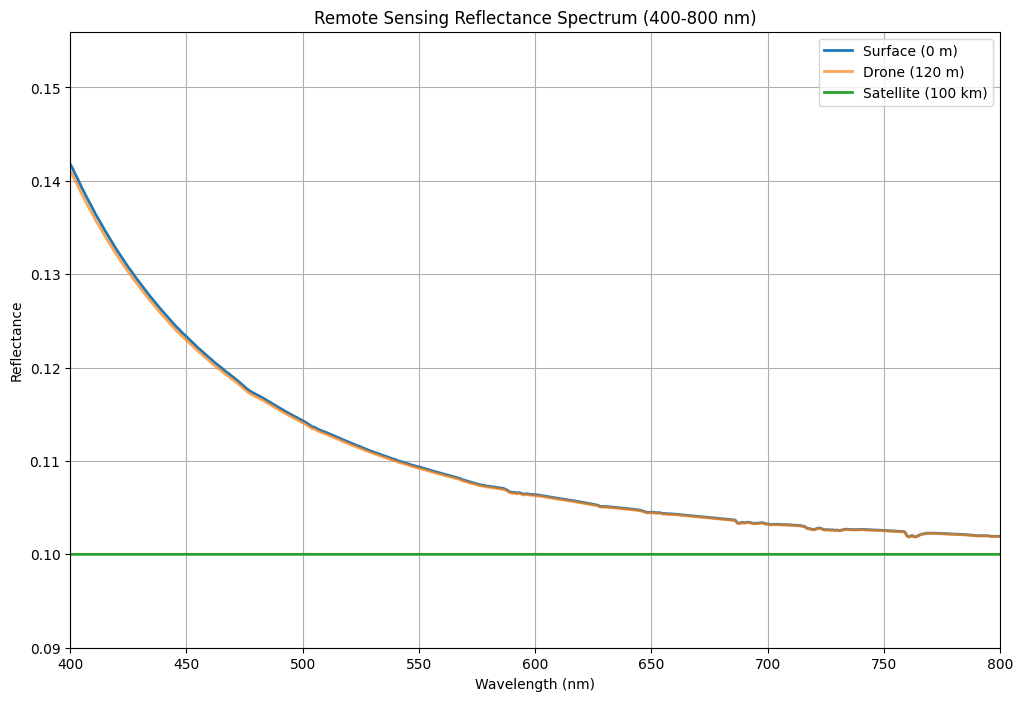

In [58]:
# load data
SC1_0m = np.loadtxt('Data/SC1_0m.OUT')
SC1_0m = pd.DataFrame(SC1_0m, columns=['lambda', 'edir', 'edn', 'eup', 'uavgdir', 'uavgdn', 'uavgup'])
SC1_0m['reflectance'] = SC1_0m['eup'] / SC1_0m['edir'] 

SC1_120m = np.loadtxt('Data/SC1_120m.OUT')
SC1_120m = pd.DataFrame(SC1_120m, columns=['lambda', 'edir', 'edn', 'eup', 'uavgdir', 'uavgdn', 'uavgup'])
SC1_120m['reflectance'] = SC1_120m['eup'] / SC1_120m['edir']

SC1_TOA = np.loadtxt('Data/SC1_TOA.OUT')
SC1_TOA = pd.DataFrame(SC1_TOA, columns=['lambda', 'edir', 'edn', 'eup', 'uavgdir', 'uavgdn', 'uavgup'])
SC1_TOA['reflectance'] = SC1_TOA['eup'] / SC1_TOA['edir']

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC1_0m)
chl_a_120m = calculate_chlorophyll_a(SC1_120m)
chl_a_TOA = calculate_chlorophyll_a(SC1_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a': [chl_a_0m, chl_a_120m, chl_a_TOA]
})

print(chl_df)

# Plot reflectance spectra
plt.figure(figsize=(12, 8))
plt.plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='Surface (0 m)', linewidth=2)
plt.plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='Drone (120 m)' , linewidth=2 , alpha=0.7)
plt.plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Remote Sensing Reflectance Spectrum (400-800 nm)')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC1_0m['reflectance'].min(), SC1_120m['reflectance'].min(), SC1_TOA['reflectance'].min())*0.9,
    max(SC1_0m['reflectance'].max(), SC1_120m['reflectance'].max(), SC1_TOA['reflectance'].max()) * 1.1
)
plt.grid(True)
plt.show()

# Scenario 2 - Clean Sky

# Scenario 3 - Oceanic Aerosols

# Scenario 4 - Adjacency Effects